In [1]:
%matplotlib inline

import torch
import torch.optim as optim
from torch.nn import Module, Sequential, Linear, LeakyReLU, BCEWithLogitsLoss
from dpm.train import train, Statistics
from dpm.visualize import plot_model, plot_models, plot_stats, plot_hist, plot_hists
from dpm.distributions import *
from dpm.distributions import MixtureModel, GumbelMixtureModel
from pprint import pprint
from dpm.criterion import forward_kl, reverse_kl
from matplotlib import pyplot as plt


In [65]:
# class FDivergence(Module):
#     def __init__(self):
#         super().__init__()
        
#     def div_function(self, ratio):
#         raise NotImplementedError()
        
#     def forward(self, p_model, q_model, batch_size=64):
#         q_samples = q_model.sample(batch_size)
#         prob = (p_model.log_prob(q_samples) \
#                 - q_model.log_prob(q_samples)).exp()
#         return self.div_function(prob).mean()
    
# class ForwardKLFDiv(FDivergence):
#     def __init__(self):
#         super(KL, self).__init__()
    
#     def div_function(self, ratio):
#         return ratio * torch.log(ratio)

# class ReverseKLFDiv(FDivergence):
#     def __init__(self):
#         super().__init__()
    
#     def div_function(self, ratio):
#         return - torch.log(ratio)


# class TotalVariationFDiv(FDivergence):
#     def __init__(self):
#         super().__init__()
    
#     def div_function(self, ratio):
#         return 0.5 * torch.abs(ratio - 1.0)
    
# class TotalVariation(Module):
#     def __init__(self):
#         super().__init__()
        
#     def forward(self, p_model, q_model, batch_size=64):
#         q_samples = q_model.sample(batch_size)
#         values = torch.abs(p_model.log_prob(q_samples).exp() \
#                            - q_model.log_prob(q_samples).exp())
#         values *= q_model.log_prob(q_samples).exp()
#         return values.mean()
    


In [112]:
class TotalVariation(Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, p_model, q_model, batch_size=64):
        mixture_model = MixtureModel([p_model, q_model], [0.5, 0.5])
        
        samples = mixture_model.sample(batch_size)
        ratio = 0.5 * ((p_model.log_prob(samples) - mixture_model.log_prob(samples)).exp() - (q_model.log_prob(samples) - mixture_model.log_prob(samples)).exp()).abs()
        return ratio.mean()

class TotalVariation(Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, p_model, q_model, batch_size=64):
        mixture_model = MixtureModel([p_model, q_model], [0.5, 0.5])
        
        samples = mixture_model.sample(batch_size)
        ratio = 0.5 * ((p_model.log_prob(samples) - mixture_model.log_prob(samples)).exp() - (q_model.log_prob(samples) - mixture_model.log_prob(samples)).exp()).abs()
        return ratio.mean()
    

#         ratio_q = 0.5 * ((p_model.log_prob(q_samples) - q_model.log_prob(q_samples)).exp() - 1.).abs()

#         p_samples = p_model.sample(batch_size)
#         ratio_p = 0.5 * ((q_model.log_prob(p_samples) - p_model.log_prob(p_samples)).exp() - 1.).abs()
# #         return ratio_p.mean()
#         return ratio_q.mean() + ratio_p.mean()
        

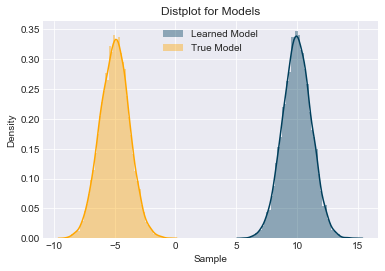

In [3]:
# p_model = MixtureModel([Normal([2.5], [[3.0]]), Normal([-2.5], [[3.0]])], [0.5,0.5])
# q_model = GumbelMixtureModel([Normal([0.0], [[1.0]]), Normal([0.0], [[1.0]])], [0.5,0.5])
p_model = Normal([-5.0], [[1.4]])
q_model = Normal([10.0], [[1.4]])
plot_models(p_model, q_model)

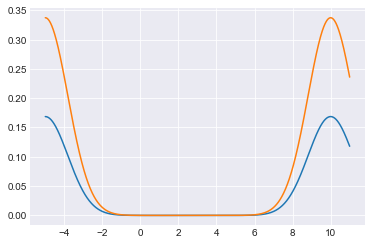

In [4]:
with torch.no_grad():
    samples = torch.tensor(np.linspace(-5, 11, 5000).reshape(-1, 1)).float()
    p_log_prob = p_model.log_prob(samples)
#     plt.plot(samples.numpy(), p_log_prob.exp().numpy())
    
#     samples = torch.tensor(np.linspace(-5, 11, 5000).reshape(-1, 1)).float()
    q_log_prob = q_model.log_prob(samples)
    plt.plot(samples.numpy(), (q_log_prob.exp() + p_log_prob.exp()).numpy() / 2)
    
    plt.plot(samples.numpy(), (p_log_prob.exp() - q_log_prob.exp()).abs().numpy())
    plt.show()

In [12]:
def total_variation(p_model, q_model, batch_size=64):
    mixture_model = MixtureModel([p_model, q_model], [0.5, 0.5])
    samples = mixture_model.sample(batch_size)
    ratio = 0.5 * ((p_model.log_prob(samples) - mixture_model.log_prob(samples)).exp() \
             - (q_model.log_prob(samples) - mixture_model.log_prob(samples)).exp()).abs()
    return ratio.mean()


def pearson(p_model, q_model, batch_size=64):
    mixture_model = MixtureModel([p_model, q_model], [0.5, 0.5])
    samples = mixture_model.sample(batch_size)
    # (t - 1)**2
    ratio = ((p_model.log_prob(samples) - mixture_model.log_prob(samples)).exp() \
             - (q_model.log_prob(samples) - mixture_model.log_prob(samples)).exp()).pow(2)
    return ratio.mean()

In [13]:
torch.manual_seed(128)
p_model = Normal([-5.0], [[1.4]])
q_model = Normal([10.0], [[1.4]])
stats = train(p_model, q_model, total_variation, 
              batch_size=128, epochs=10000, lr=0.5)

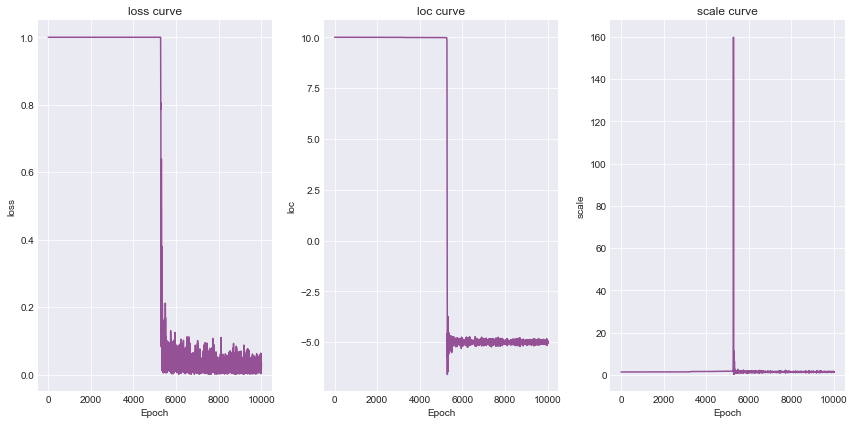

In [14]:
plot_stats(stats)

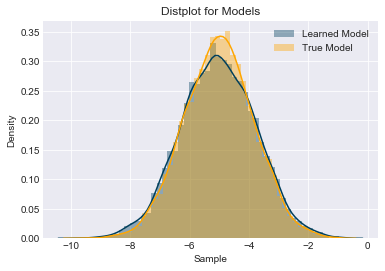

In [15]:
plot_models(p_model, q_model)

In [19]:
torch.manual_seed(128)
p_model = Normal([-5.0], [[1.4]])
q_model = Normal([10.0], [[1.4]])
stats = train(p_model, q_model, pearson, 
              batch_size=128, epochs=7000, lr=0.5)

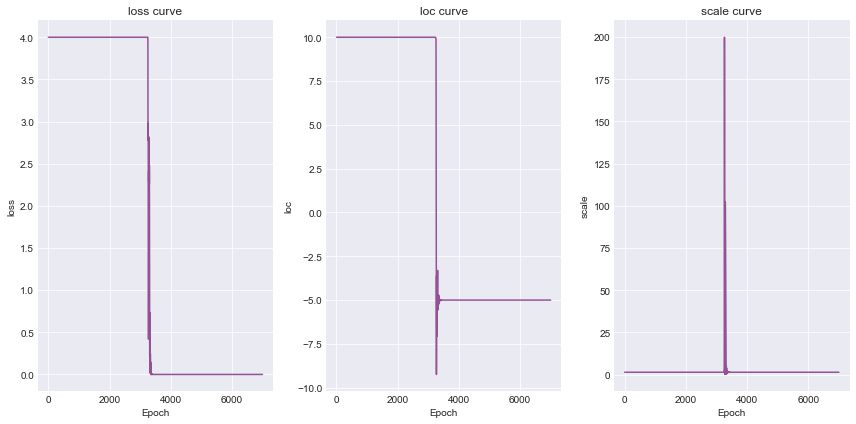

In [20]:
plot_stats(stats)

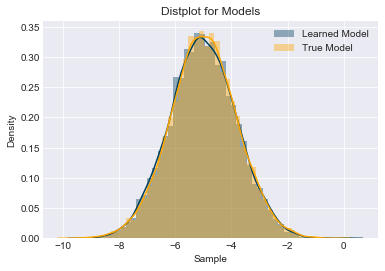

In [21]:
plot_models(p_model, q_model)

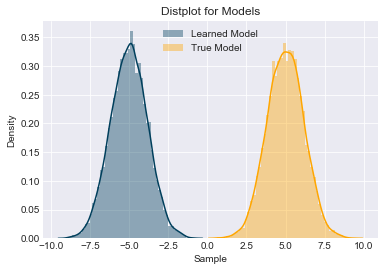

RuntimeError: Lapack Error in potrf : the leading minor of order 1 is not positive definite at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensorLapack.cpp:658

In [11]:
class FDivergence(Module):
    def __init__(self):
        super().__init__()
        
    def f_function(self, ratio):
        raise NotImplementedError()
        
    def forward(self, p_model, q_model, batch_size=64):
        
        
        mixture_model = MixtureModel([p_model, q_model], [0.5, 0.5])
        
        samples = mixture_model.sample(batch_size)
        
        
        prob = (p_model.log_prob(samples) \
                - q_model.log_prob(samples)).exp()
        return (self.f_function(prob) * (q_model.log_prob(samples) - mixture_model.log_prob(samples)).exp()).mean()


class ForwardKLFDiv(FDivergence):
    def __init__(self):
        super().__init__()
    
    def f_function(self, ratio):
        return ratio * torch.log(ratio)


# p_model = MixtureModel([Normal([2.5], [[3.0]]), Normal([-2.5], [[3.0]])], [0.5,0.5])
# q_model = GumbelMixtureModel([Normal([0.0], [[1.0]]), Normal([0.0], [[1.0]])], [0.5,0.5])

torch.manual_seed(40)
p_model = Normal([5.0], [[1.4]])
q_model = Normal([-5.0], [[1.4]])

plot_models(p_model, q_model)
plt.show()

stats = Statistics()
stats = train(p_model, q_model, ForwardKLFDiv(), clip_gradients=0.1, optimizer='Adamax',
              batch_size=256, epochs=4000, lr=0.01, stats=stats)
plot_stats(stats)
plt.show()

plot_models(p_model, q_model)
plt.show()

In [9]:
stats = train(p_model, q_model, ForwardKLFDiv(), 
              batch_size=256, epochs=2000, lr=0.001, stats=stats)


RuntimeError: Lapack Error in potrf : the leading minor of order 1 is not positive definite at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensorLapack.cpp:658

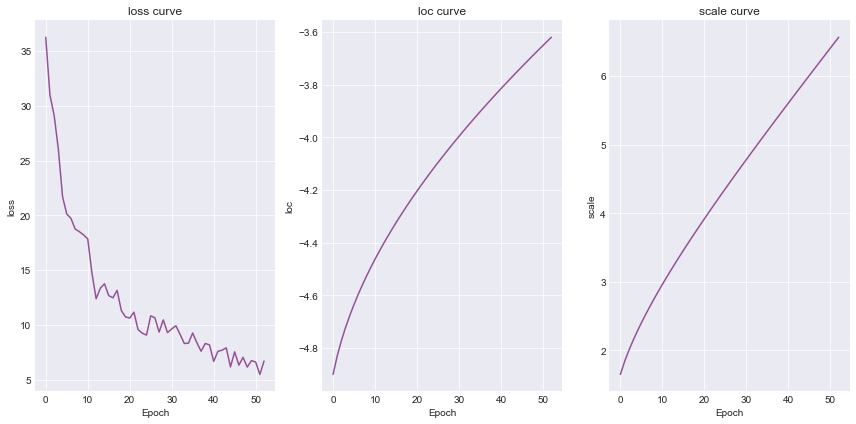

RuntimeError: Lapack Error in potrf : the leading minor of order 1 is not positive definite at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensorLapack.cpp:658

In [10]:
plot_stats(stats)
plt.show()

plot_models(p_model, q_model)
plt.show()

In [9]:
q_model.scale

tensor([[nan]], grad_fn=<MmBackward>)

In [148]:
from numpy.polynomial.hermite import hermgauss

def integrate(function, n_points=10):
    
    x, weights = hermgauss(n_points)
    x = torch.tensor(x, dtype=torch.float32)
    weights = torch.tensor(weights, dtype=torch.float32)
    f_values = function(x.view(-1, 1))
    f_values[f_values == float("Inf")] = 0.
    return (weights * f_values).sum()

def tv(p_model, q_model, batch_size):
    # Explain why denominator needs to be there for integrate
    
    return integrate(lambda x: (p_model.log_prob(x).exp() - q_model.log_prob(x).exp()).abs() / (- x.view(-1) ** 2).exp(), batch_size)

def tv(p_model, q_model, batch_size):
    # Explain why denominator needs to be there for integrate
    
    return integrate(lambda x: (p_model.log_prob(x).exp() - q_model.log_prob(x).exp()).abs() / (- x.view(-1) ** 2).exp(), batch_size)

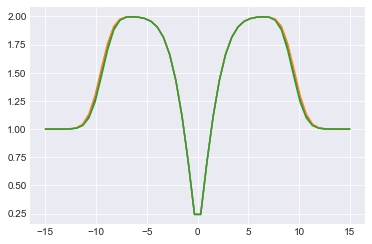

In [155]:
tv_values = []
mus = np.linspace(-15, 15, 50)
for mu in mus:
    q_model = Normal([mu], [[1.]])
    p_model = Normal([0.0], [[1.]])

    values = []
    for i in range(90, 100):
        values.append(tv(p_model, q_model, i).item())
    values = np.array(values)
    tv_values.append((values.mean(), values.std()))
#     plt.plot(values)
plt.plot(mus, [m for (m, _) in tv_values])
plt.plot(mus, [m+s for (m, s) in tv_values])
plt.plot(mus, [m-s for (m, s) in tv_values])

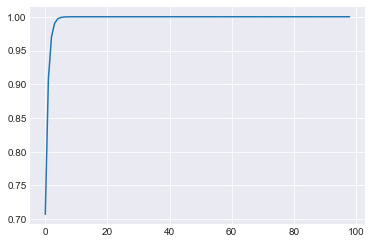

In [149]:
p_model = Normal([-15.0], [[1.4]])
q_model = Normal([0.0], [[1.]])

values = []
for i in range(1, 100):
    values.append(tv(p_model, q_model, i))
plt.plot(values)

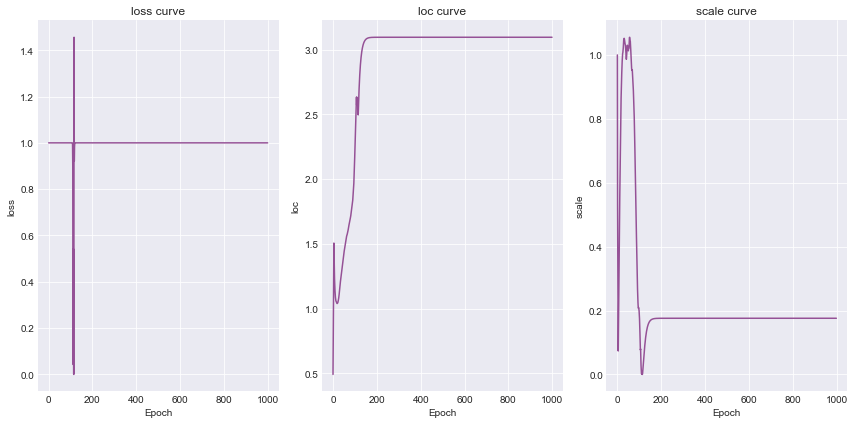

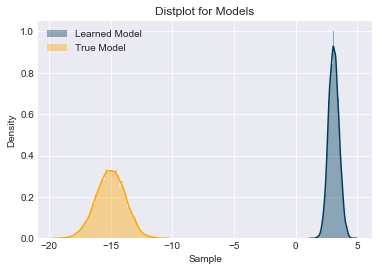

In [150]:
p_model = Normal([-15.0], [[1.4]])
q_model = Normal([0.0], [[1.]])

stats = Statistics()
stats = train(p_model, q_model, tv, optimizer='Adamax',
              batch_size=60, epochs=1000, lr=0.6, stats=stats)
plot_stats(stats)
plt.show()

plot_models(p_model, q_model)
plt.show()

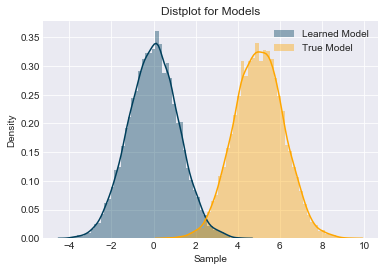

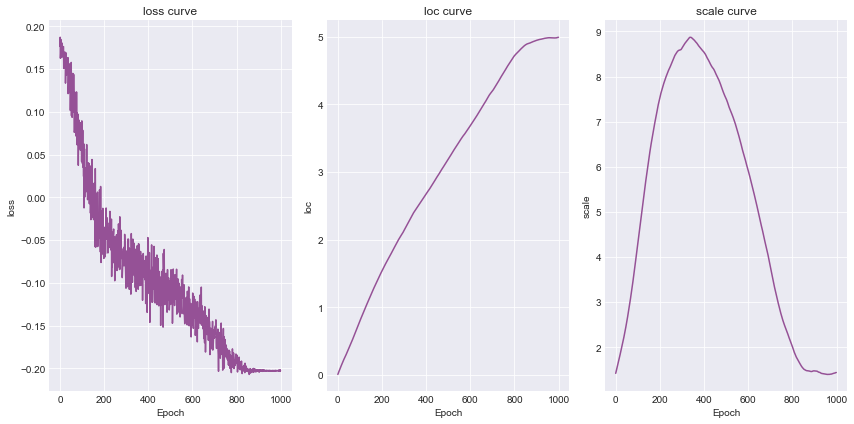

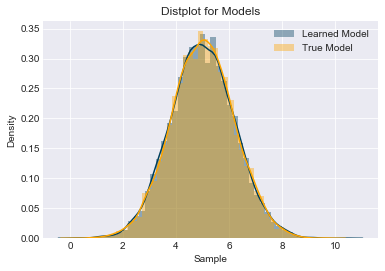

In [159]:

def _forward_kl(p_model, q_model, batch_size=64):
    p_samples = p_model.sample(batch_size)
    return (p_model.log_prob(p_samples) - q_model.log_prob(p_samples)).mean()

def _other_term(p_model, q_model, batch_size):
    p_samples = p_model.sample(batch_size)
    p_log_prob = p_model.log_prob(p_samples)
    q_log_prob = q_model.log_prob(p_samples)
    return (torch.logsumexp(torch.stack([p_log_prob, q_log_prob]), dim=0) - torch.logsumexp(torch.stack([p_log_prob, q_log_prob, q_log_prob]), dim=0)).mean()

def js_divergence_2(p_model, q_model, batch_size=64):
    M = MixtureModel([p_model, q_model], [0.5, 0.5])
    return 0.5 * (_other_term(p_model, M, batch_size)
                  + _forward_kl(q_model, M, batch_size))

torch.manual_seed(40)
p_model = Normal([5.0], [[1.4]])
q_model = Normal([0.0], [[1.4]])

plot_models(p_model, q_model)
plt.show()

stats = Statistics()
stats = train(p_model, q_model, js_divergence, clip_gradients=0.1, optimizer='Adamax',
              batch_size=256, epochs=1000, lr=0.01, stats=stats)
plot_stats(stats)
plt.show()

plot_models(p_model, q_model)
plt.show()